# Standard Study Validation

Here I will try to validate the rules found here: https://www.notion.so/d3b/Standard-Study-Validation-935bc971bd1141f0a3d76a2a9caca461. 

In [88]:
from collections import Counter, defaultdict
from pprint import pprint
from kf_lib_data_ingest.common.io import read_df

import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline

In [77]:
# Load dummy data

def load_csv(path):
    return pd.read_csv(path, dtype=str)

NA = ""

filenames = ['data1/{}.csv'.format(file) for file in 'pf pg sp sg spf sfp2'.split()]

data_files = [read_df(path, encoding="utf-8-sig").replace("NA", NA) for path in filenames]

for filename, data_file in zip(filenames, data_files):
    data_file.name = filename
    
pf, pg, sp, sg, spf, spf2 = data_files

In [81]:
pf.name

'data1/pf.csv'

In [11]:
pg

,PARTICIPANT|ID,GENOMIC_FILE|URL_LIST
0,P4,['foo/s5.txt']
1,P9,['foo/s9.txt']
2,P10,['foo/s11.txt']


In [12]:
sp

,BIOSPECIMEN|ID,PARTICIPANT|ID
0,S7,P5
1,S10,P6
2,S11,P10


In [13]:
sg

,BIOSPECIMEN|ID,GENOMIC_FILE|URL_LIST
0,S7,['foo/s7.txt']
1,S10,['foo/s10.txt']


In [14]:
spf

,BIOSPECIMEN|ID,PARTICIPANT|ID,FAMILY|ID
0,S1,P1,F1
1,S2,P1,F1
2,S3,P3,F1
3,S4,P3,
4,S5,P4,F2
5,S6,P5,F2
6,S7,,F2
7,S8,,
8,S9,P9,F9


In [15]:
spf2

,BIOSPECIMEN|ID,PARTICIPANT|ID,FAMILY|ID
0,S7,P5,F2
1,,P6,F3
2,S2,P2,F1


In [17]:
def df_to_graph(G, df):
    columns = df.columns.values
    for index, row in df.iterrows():
        row_list = list(row)
        for i, item in enumerate(row_list[:-1]):
            left_node = {
                "type": columns[i],
                "ID": item
            }
            
            right_node = {
                "type": columns[i + 1],
                "ID": row_list[i + 1]
            }
            
            if left_node["ID"] not in G.nodes:
                G.add_node(left_node["ID"])
                G.nodes[left_node["ID"]]["type"] = left_node["type"]
            if right_node["ID"] not in G.nodes:
                G.add_node(right_node["ID"])
                G.nodes[right_node["ID"]]["type"] = right_node["type"]
                
            G.add_edge(left_node["ID"], right_node["ID"])

In [18]:
G = nx.Graph()
for df in data_files:
    df_to_graph(G, df)

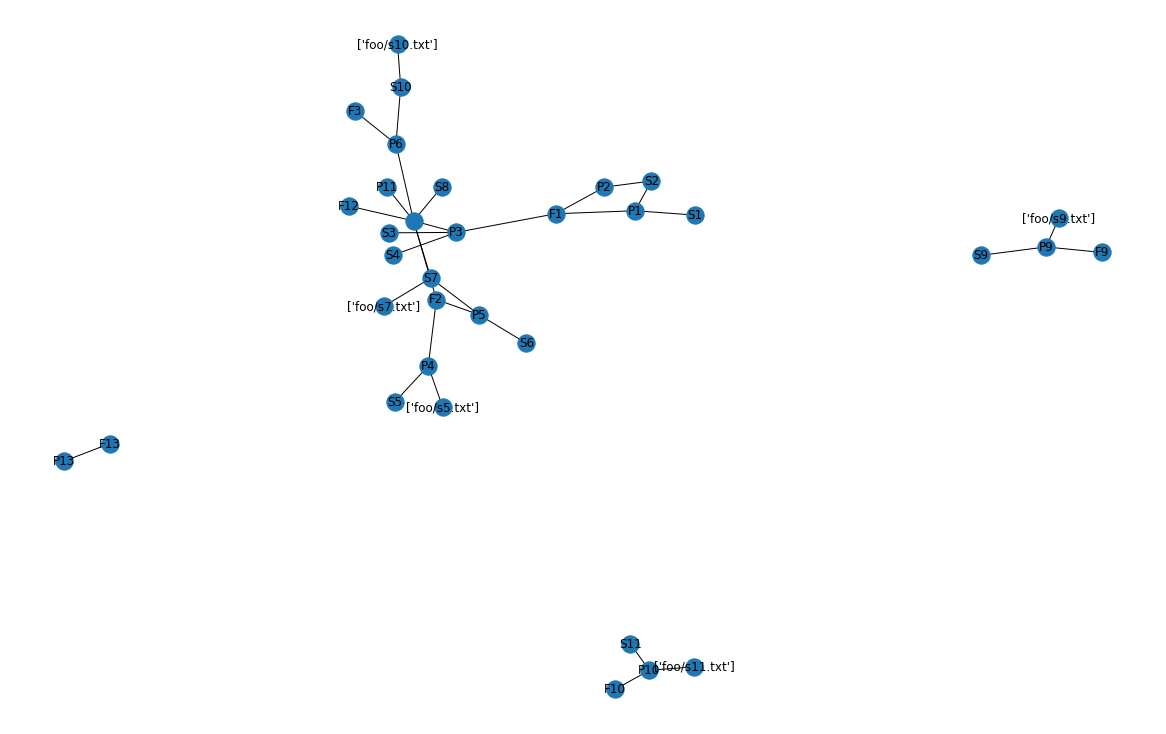

In [19]:
plt.figure(figsize=(16,10))
nx.draw(G, with_labels=True)

So here we have major clumping. This is because patients in the same family are connected, so all their associated biospecimens and files and stuff will get connected as well. When creating the edges we need to make family nodes a special case. Also need to figure out how to handle `nan`s. 

In [119]:
FAMILY_ID = "FAMILY|ID"

class Node(object):
    def __init__(self, node_type, data):
        self.type = node_type
        self.data = data
        self.family = self.type == FAMILY_ID
        self.visible = bool(self.data)
        

In [120]:
familyIDs = []

def new_df_to_graph(G, df):
    columns = df.columns.values
    for index, row in df.iterrows():
        row_list = list(row)
        for i, item in enumerate(row_list[:-1]):
            
            left_node = Node(node_type=columns[i], data=item)
            right_node = Node(
                node_type=columns[i + 1],
                data=row_list[i + 1]
            )

            if left_node.visible:
                G.add_node(left_node.data, type=left_node.type, file=df.name)
                if left_node.family:
                    familyIDs.append(left_node.data)
            if right_node.visible:
                G.add_node(right_node.data, type=right_node.type, file=df.name)
                if right_node.family:
                    familyIDs.append(right_node.data)
                
            if left_node.visible and right_node.visible:
                G.add_edge(left_node.data, right_node.data)

In [121]:
G = nx.Graph()
for df in data_files:
    new_df_to_graph(G, df)

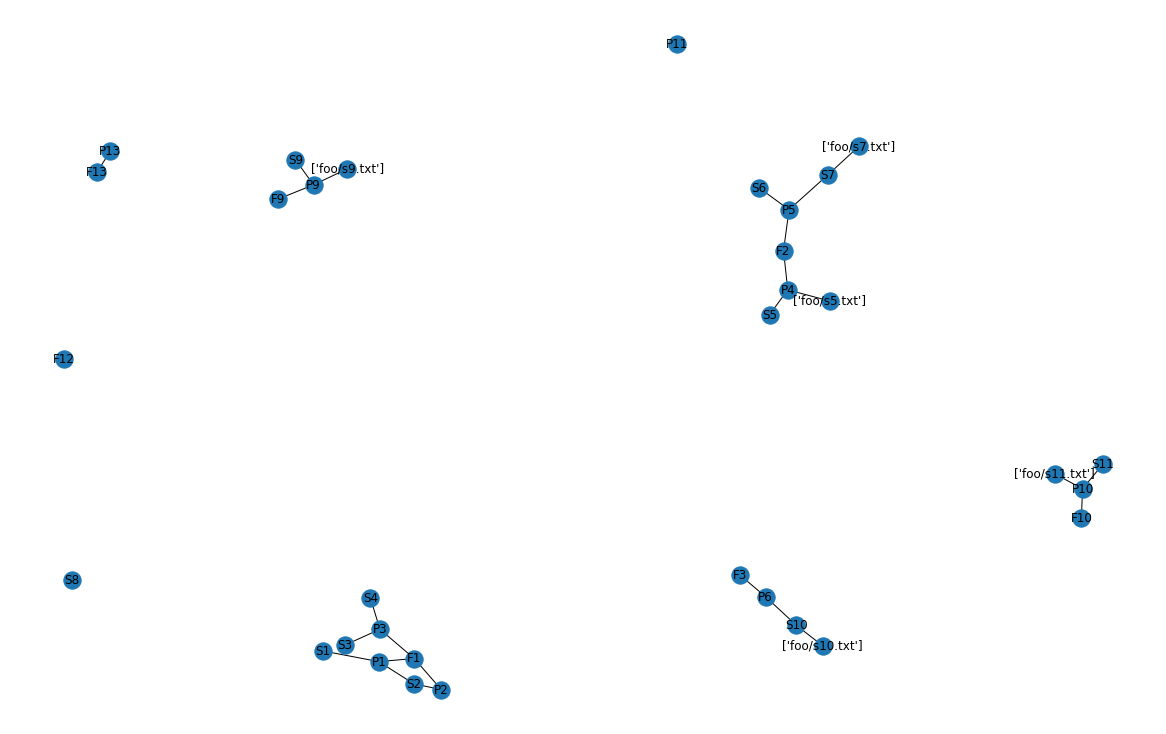

In [122]:
plt.figure(figsize=(16,10))
nx.draw(G, with_labels=True)

In [ ]:
# Now process the family relationships, then prune the associated nodes to make the tests easier


In [85]:
def check_relationship_2(G):
    """
    Takes in a connected subgraph (which hopefully represents a single patient and their associated data),
    and checks for the 2nd relationship as defined in notion. This relationship is that a Specimen comes from 1
    Participant. Returns a bool representing this check.
    """
    subgraphs = list(nx.connected_components(G))
    for subgraph in subgraphs:
        for index in subgraph:
            node = G.nodes[index]
            # In order to differentiate between bad specimens and bad genomic files we need to examine each biospecimens edges
            num_parts = 0
            
            if node["type"] == "BIOSPECIMEN|ID":            
                for edge in G.edges(index):
                    if G.nodes[edge[1]]["type"] == "PARTICIPANT|ID":
                        num_parts += 1

                if num_parts > 1:
                    return False
    return True
            

In [92]:
def subgraph_counts(G):
    """
    Given graph G counts the number of each type of node in each connected sub-component.
    These counts can be used to easily perform the validation tests.
    """
    subgraphs = list(nx.connected_components(G))
    types = {}
    for subgraph in subgraphs:
        sub_dict = {
            "PARTICIPANT|ID": [],
            "GENOMIC_FILE|URL_LIST": [],
            "BIOSPECIMEN|ID": []
        }
        
        for index in subgraph:
            node = G.nodes[index]
            sub_dict[node["type"]].append(index)
            
        types[tuple(subgraph)] = sub_dict
            
    return types

In [93]:
types = subgraph_counts(G)
pprint(types)

{('P1', 'P2', 'S2', 'S1'): {'BIOSPECIMEN|ID': ['S2', 'S1'],
                            'GENOMIC_FILE|URL_LIST': [],
                            'PARTICIPANT|ID': ['P1', 'P2']},
 ('P11',): {'BIOSPECIMEN|ID': [],
            'GENOMIC_FILE|URL_LIST': [],
            'PARTICIPANT|ID': ['P11']},
 ('P13',): {'BIOSPECIMEN|ID': [],
            'GENOMIC_FILE|URL_LIST': [],
            'PARTICIPANT|ID': ['P13']},
 ('P9', "['foo/s9.txt']", 'S9'): {'BIOSPECIMEN|ID': ['S9'],
                                  'GENOMIC_FILE|URL_LIST': ["['foo/s9.txt']"],
                                  'PARTICIPANT|ID': ['P9']},
 ('S10', "['foo/s10.txt']", 'P6'): {'BIOSPECIMEN|ID': ['S10'],
                                    'GENOMIC_FILE|URL_LIST': ["['foo/s10.txt']"],
                                    'PARTICIPANT|ID': ['P6']},
 ('S4', 'P3', 'S3'): {'BIOSPECIMEN|ID': ['S4', 'S3'],
                      'GENOMIC_FILE|URL_LIST': [],
                      'PARTICIPANT|ID': ['P3']},
 ('S7', 'P5', 'S6', "['foo/s7.

In [97]:
def new_check_relationship_2(types):
    bad_biospecimens = []
    for component in types:
        if types[component]["BIOSPECIMEN|ID"]:
            if len(types[component]["PARTICIPANT|ID"]) != 1:
                bad_biospecimens.extend(types[component]["BIOSPECIMEN|ID"])
            
    return bad_biospecimens
        

In [98]:
new_check_relationship_2(types)

['S2', 'S1', 'S8']

In [105]:
def check_relationship_3(types):
    """
    A Participant is linked to at least 1 Specimen
    """
    bad_participants = []
    for component in types:
        if types[component]["PARTICIPANT|ID"]:
            if not counts[component]["BIOSPECIMEN|ID"]:
                bad_participants.extend(types[component]["PARTICIPANT|ID"])
            
    return bad_participants

In [106]:
check_relationship_3(types)

['P11', 'P13']

In [107]:
def check_relationship_5(types):
    """
    A Source Seq File Manifest Record is linked to exactly 1 Specimen
    """
    bad_seq_files = []
    for component in types:
        if types[component]["GENOMIC_FILE|URL_LIST"]:
            if not types[component]["BIOSPECIMEN|ID"]:
                bad_seq_files.extend(types[component]["GENOMIC_FILE|URL_LIST"])
                
    return bad_seq_files
    

In [109]:
check_relationship_5(types)

[]

In [115]:
def check_relationship_7(G, types):
    """
    A Participant is in at least 1 Family Group
    """
    participants = [
        part
        for component in types
        for part in types[component]["PARTICIPANT|ID"]
    ]
    
    bad_parts = []
    for part in participants:
        if not G.nodes[part]["family"]:
            bad_parts.append(part)
            
    return bad_parts

In [116]:
check_relationship_7(G, types)

['P11', 'P3']

In [68]:
G.nodes['P10']

{'type': 'PARTICIPANT|ID', 'family': 'F10'}